# 🔋 Ekstraksi Parameter Baterai dari HPPC Test (10 Loop Penuh)
**Tujuan:** Mendapatkan nilai Hambatan Dalam Ohmic ($R_0$), Hambatan Polarisasi ($R_1$), Kapasitansi ($C_1$), dan Tegangan Sirkuit Terbuka (OCV) pada setiap interval 10% State of Charge (SoC).

**Dataset:** File pengujian Pulse Discharge (10 Loop) yang dieksekusi terus-menerus tanpa putus. Parameter ini adalah inti dari algoritma *Extended Kalman Filter* (EKF) pada Smart BMS.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Konfigurasi Tampilan Plot
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

### 1. Pembacaan Data Mentah & Visualisasi Kurva HPPC
Kita membersihkan data dari header bawaan software ZKETECH dan mem-plot kurva "Tangga" HPPC.

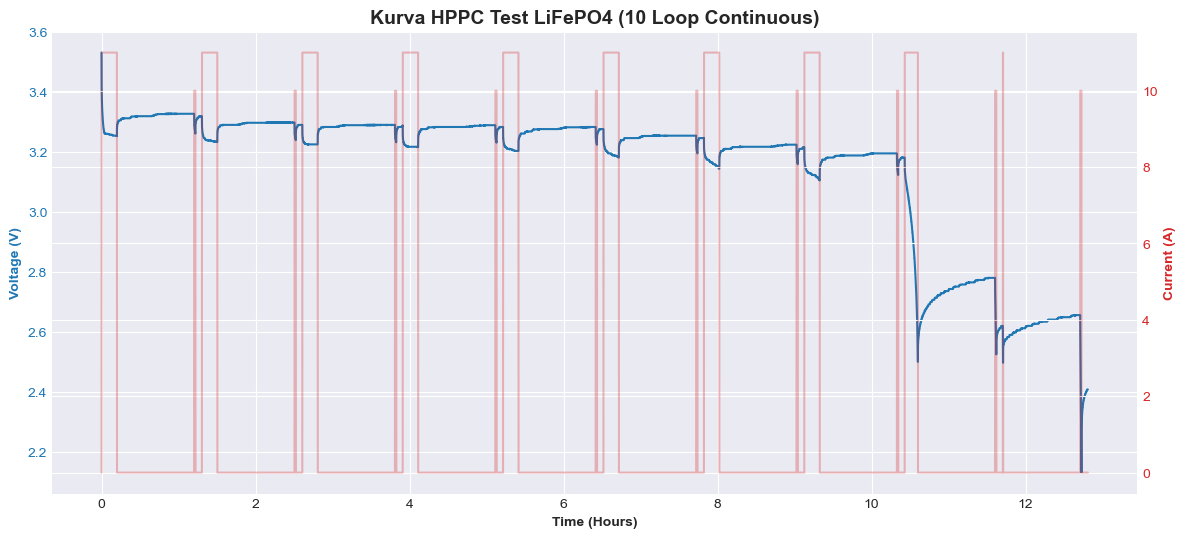

In [2]:
def load_zke_hppc(filepath):
    skip_rows = 0
    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if "Time(S)" in line:
                skip_rows = i
                break
    
    df = pd.read_csv(filepath, skiprows=skip_rows)
    df.columns = [col.strip() for col in df.columns]
    return df

# LOAD FILE KAMU DI SINI
filename_hppc = "hppc (loop10x).csv"
df = load_zke_hppc(filename_hppc)

# Plot Kurva Keseluruhan
fig, ax1 = plt.subplots()

ax1.plot(df['Time(S)']/3600, df['Vol(V)'], color='tab:blue', label='Voltage (V)')
ax1.set_xlabel('Time (Hours)', fontweight='bold')
ax1.set_ylabel('Voltage (V)', color='tab:blue', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(df['Time(S)']/3600, df['Cur(A)'], color='tab:red', alpha=0.3, label='Current (A)')
ax2.set_ylabel('Current (A)', color='tab:red', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Kurva HPPC Test LiFePO4 (10 Loop Continuous)', fontsize=14, fontweight='bold')
plt.show()

### 2. Ekstraksi $R_0, R_1, C_1$ (Membuat Lookup Table)
Algoritma di bawah ini akan melacak setiap kali terjadi tarikan arus pulse 10A, lalu mencocokkan lengkungan penurunan tegangannya menggunakan rumus **Equivalent Circuit Model (ECM)**.

$$V(t) = OCV - I \cdot R_0 - I \cdot R_1 \cdot (1 - e^{\frac{-t}{R_1 \cdot C_1}})$$


In [3]:
# 1. Deteksi Kapan Pulse 10A Terjadi
is_pulse = (df['Cur(A)'] > 9.0) & (df['Cur(A)'] < 10.5)
pulse_starts = df.index[is_pulse.astype(int).diff() == 1].tolist()
pulse_ends = df.index[is_pulse.astype(int).diff() == -1].tolist()

print(f"✅ Berhasil mendeteksi {min(len(pulse_starts), len(pulse_ends))} Pulse di dalam data.\n")

results = []
I_pulse = 10.0 # Ampere Discharge Pulse

for i in range(min(len(pulse_starts), len(pulse_ends))):
    start = pulse_starts[i]
    end = pulse_ends[i]
    
    # Ambil Tegangan sebelum pulse dimulai (OCV)
    OCV = df.loc[start - 1, 'Vol(V)']
    t_start = df.loc[start, 'Time(S)']
    
    # Ekstrak data tegangan selama pulse 1 menit
    df_pulse = df.loc[start:end-1]
    t = df_pulse['Time(S)'] - t_start
    V = df_pulse['Vol(V)']
    
    # Hitung nilai awal R0 (Voltage Drop awal -> Mirip skrip MATLAB dosen)
    R0_guess = (OCV - V.iloc[0]) / I_pulse
    if R0_guess < 0: R0_guess = 0.001
    
    # Model Matematika ECM
    def ecm_model(t, R0, R1, C1):
        return OCV - I_pulse * R0 - I_pulse * R1 * (1 - np.exp(-t / (R1 * C1)))
    
    # Fitting Kurva dengan batas (bounds) agar parameter tidak negatif
    try:
        popt, _ = curve_fit(ecm_model, t, V, p0=[R0_guess, 0.01, 1000], bounds=(0, [1, 1, 100000]))
        R0, R1, C1 = popt
        
        # Penamaan SoC (Tiap loop turun 10%, mulai dari 90%)
        soc = 90 - (i * 10)
        
        results.append({
            'SoC (%)': soc, 
            'OCV (V)': OCV, 
            'R0 (mOhm)': R0 * 1000, # Konversi Ohm ke mOhm
            'R1 (mOhm)': R1 * 1000, 
            'C1 (F)': C1
        })
    except Exception as e:
        print(f"Gagal fitting Pulse {i+1}: {e}")

# Buat Tabel Hasil
df_params = pd.DataFrame(results)

# Tampilkan Lookup Table dengan format yang rapi
df_display = df_params.round({'OCV (V)': 4, 'R0 (mOhm)': 2, 'R1 (mOhm)': 2, 'C1 (F)': 1})
display(df_display)

✅ Berhasil mendeteksi 10 Pulse di dalam data.



,SoC (%),OCV (V),R0 (mOhm),R1 (mOhm),C1 (F)
0,90,3.326,2.79,5.19,8591.2
1,80,3.297,2.96,3.53,9944.5
2,70,3.289,2.88,3.56,10288.7
3,60,3.288,2.95,3.31,8639.0
4,50,3.282,2.89,3.40,8279.9
5,40,3.253,2.59,3.84,7638.4
6,30,3.223,3.19,4.14,8499.3
7,20,3.194,2.98,5.38,7056.3
8,10,2.779,2.51,1000.00,2625.1
9,0,2.655,1.06,1000.00,1119.5


### 3. Visualisasi Hasil Ekstraksi
Grafik ini memvalidasi apakah perubahan hambatan dalam ($R_0$ dan $R_1$) masuk akal secara kimiawi. Biasanya resistansi ($R$) akan naik perlahan dan melonjak drastis saat SoC mendekati 0%.

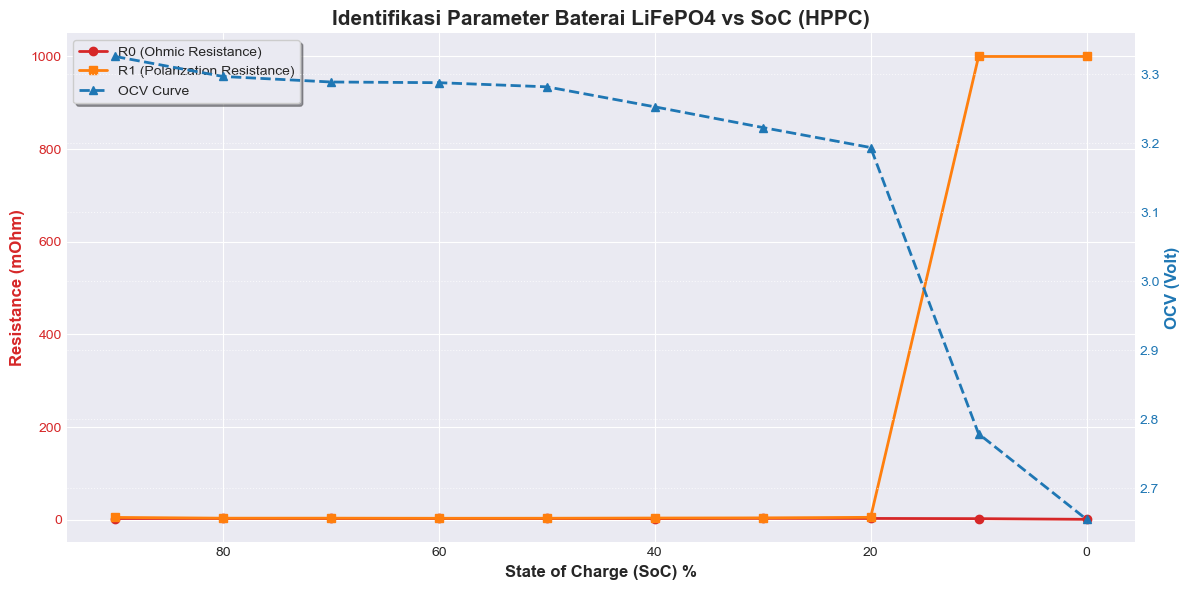

In [4]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Resistance di Sumbu Y Kiri
ax1.set_xlabel('State of Charge (SoC) %', fontweight='bold', fontsize=12)
ax1.set_ylabel('Resistance (mOhm)', color='tab:red', fontweight='bold', fontsize=12)
ax1.plot(df_params['SoC (%)'], df_params['R0 (mOhm)'], marker='o', color='tab:red', linewidth=2, label='R0 (Ohmic Resistance)')
ax1.plot(df_params['SoC (%)'], df_params['R1 (mOhm)'], marker='s', color='tab:orange', linewidth=2, label='R1 (Polarization Resistance)')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.invert_xaxis() # Balik Sumbu X agar SoC menurun dari 90 ke 0

# Plot OCV di Sumbu Y Kanan
ax2 = ax1.twinx()
ax2.set_ylabel('OCV (Volt)', color='tab:blue', fontweight='bold', fontsize=12)
ax2.plot(df_params['SoC (%)'], df_params['OCV (V)'], marker='^', color='tab:blue', linewidth=2, linestyle='--', label='OCV Curve')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Menyatukan Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True, shadow=True)

plt.title('Identifikasi Parameter Baterai LiFePO4 vs SoC (HPPC)', fontsize=15, fontweight='bold')
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

### 4. Membangun "Lookup Functions" (Interpolasi)
EKF membutuhkan nilai $R_0, R_1, C_1$, dan OCV secara berkesinambungan (kontinu). 
Karena data kita terpisah-pisah per 10% (90%, 80%, dst), kita menggunakan fungsi interpolasi `interp1d` dari SciPy. Jika algoritma menanyakan nilai pada SoC 85%, fungsi ini akan memberikan nilai tengah yang akurat.

In [5]:
from scipy.interpolate import interp1d

# Mengubah nilai mOhm kembali ke Ohm (Standar Satuan Fisika untuk EKF)
SoC_ref = df_params['SoC (%)'].values / 100.0  # Ubah ke skala 0.0 - 1.0
OCV_ref = df_params['OCV (V)'].values
R0_ref  = df_params['R0 (mOhm)'].values / 1000.0
R1_ref  = df_params['R1 (mOhm)'].values / 1000.0
C1_ref  = df_params['C1 (F)'].values

# Membuat fungsi Interpolasi (Lookup Table Otomatis)
f_OCV = interp1d(SoC_ref, OCV_ref, kind='cubic', fill_value='extrapolate')
f_R0  = interp1d(SoC_ref, R0_ref, kind='linear', fill_value='extrapolate')
f_R1  = interp1d(SoC_ref, R1_ref, kind='linear', fill_value='extrapolate')
f_C1  = interp1d(SoC_ref, C1_ref, kind='linear', fill_value='extrapolate')

# EKF (Matriks Jacobian) membutuhkan nilai turunan kurva OCV terhadap SoC (dOCV/dSoC)
def get_dOCV_dSoC(soc):
    delta = 0.001
    return (f_OCV(soc + delta) - f_OCV(soc - delta)) / (2 * delta)

print("✅ Fungsi Lookup Table (Interpolasi) siap digunakan!")

✅ Fungsi Lookup Table (Interpolasi) siap digunakan!


### 5. Algoritma Utama: Extended Kalman Filter (EKF)
Di sini kita mendefinisikan kelas `BatteryEKF`. EKF menggunakan dua langkah utama pada setiap detiknya:
1. **Predict:** Menghitung sisa kapasitas menggunakan arus (*Coulomb Counting*).
2. **Update:** Membandingkan tegangan tebakan model vs tegangan asli sensor. Selisihnya (error) akan dikalikan dengan **Kalman Gain** untuk mengoreksi tebakan SoC agar tidak terjadi akumulasi *error*.

In [6]:
class BatteryEKF:
    def __init__(self, Q_Ah, dt):
        self.Q = Q_Ah * 3600.0  # Kapasitas total baterai dalam satuan Coulomb (A.s)
        self.dt = dt            # Sampling time (Waktu antar baris data, detik)
        
        # Inisialisasi State (x) = [SoC, Tegangan_Polarisasi (Vc1)]
        self.x = np.array([[1.0],   # Asumsi mulai dari 100% (1.0)
                           [0.0]])  # Vc1 awal adalah 0 Volt
        
        # Matriks Kovariansi Error (P) - Menggambarkan kepercayaan EKF terhadap tebakannya
        self.P = np.array([[0.01, 0.0], 
                           [0.0, 0.01]])
        
        # Process Noise (Q) - Ketidakpastian model matematis
        self.Q_noise = np.array([[1e-6, 0.0], 
                                 [0.0, 1e-5]])
        
        # Measurement Noise (R) - Ketidakpastian/Noise dari sensor tegangan
        self.R_noise = np.array([[1e-2]])
        
    def step(self, I, V_meas):
        # 1. Ambil state lama
        soc = float(self.x[0, 0])
        vc1 = float(self.x[1, 0])
        
        # Batasi SoC agar tidak "jebol" batas logika (1% hingga 99%)
        soc = np.clip(soc, 0.01, 0.99)
        
        # 2. Panggil parameter dari Lookup Table berdasarkan SoC saat ini
        R0 = float(f_R0(soc))
        R1 = float(f_R1(soc))
        C1 = float(f_C1(soc))
        OCV = float(f_OCV(soc))
        
        # =======================================================
        # STEP 1: PREDICT (Tebak State Selanjutnya)
        # =======================================================
        # Prediksi SoC (Rumus Coulomb Counting dasar) -> Arus positif = Discharge
        soc_pred = soc - (I * self.dt / self.Q)
        
        # Prediksi Tegangan Polarisasi RC
        exp_term = np.exp(-self.dt / (R1 * C1))
        vc1_pred = vc1 * exp_term + R1 * (1 - exp_term) * I
        
        self.x = np.array([[soc_pred], [vc1_pred]])
        
        # Matriks Jacobian Transisi State (A)
        A = np.array([[1.0, 0.0],
                      [0.0, exp_term]])
        
        # Update Error Covariance (P)
        self.P = A @ self.P @ A.T + self.Q_noise
        
        # =======================================================
        # STEP 2: UPDATE (Koreksi dengan Data Sensor)
        # =======================================================
        # Prediksi berapakah tegangan Terminal (V) jika state-nya seperti tebakan di atas?
        V_pred = OCV - vc1_pred - (I * R0)
        
        # Matriks Jacobian Pengukuran (H)
        dOCV = get_dOCV_dSoC(soc_pred)
        H = np.array([[dOCV, -1.0]])
        
        # Hitung Kalman Gain (Seberapa kita percaya pada alat ukur vs model matematika?)
        S = H @ self.P @ H.T + self.R_noise
        K = self.P @ H.T @ np.linalg.inv(S)
        
        # Selisih/Error antara Tegangan Sensor Asli vs Tebakan Model
        error = V_meas - V_pred
        
        # KOREKSI FINAL STATE (SoC dan Vc1 yang baru!)
        self.x = self.x + (K * error)
        
        # Update matriks P setelah koreksi
        I_mat = np.eye(2)
        self.P = (I_mat - K @ H) @ self.P
        
        # Return SoC akhir dan Tegangan Prediksi untuk disimpan
        return float(self.x[0, 0]), V_pred

### 6. Uji Coba: Membandingkan Kinerja EKF pada Data HPPC
Kita akan memutar ulang rekaman data HPPC dari detik awal hingga akhir, dan membiarkan "Otak EKF" menebak tegangan sirkuitnya. Jika garis estimasinya menempel pada garis asli sensor, berarti identifikasi R0, R1, dan C1 kita sangat akurat!

Sampling time terdeteksi: 2.0 detik per baris data.


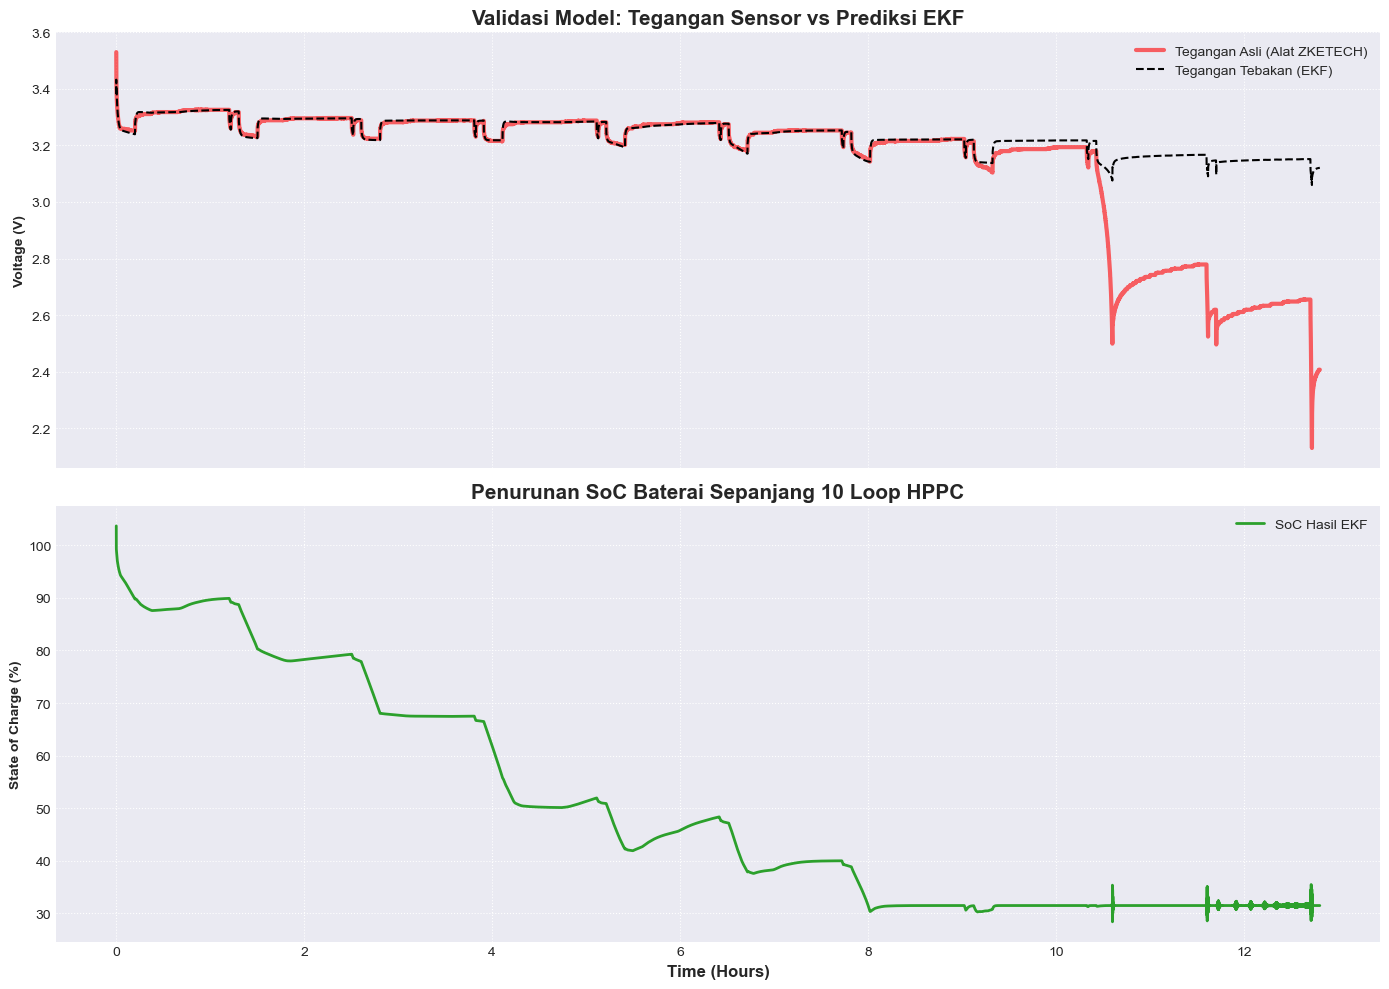

In [7]:
# Cek Sampling Time aktual dari alat (Biasanya 1 atau 2 detik per baris)
dt_actual = df['Time(S)'].diff().median()
print(f"Sampling time terdeteksi: {dt_actual} detik per baris data.")

# Inisialisasi EKF dengan kapasitas total aktual kita (21.13 Ah)
ekf = BatteryEKF(Q_Ah=21.13, dt=dt_actual)

# Siapkan list kosong untuk menyimpan tebakan EKF dari waktu ke waktu
soc_ekf_history = []
v_pred_history = []

# ================= SIMULASI REAL-TIME =================
# Looping ini mensimulasikan seolah-olah data masuk per detik ke mikrokontroler
for i in range(len(df)):
    arus_masuk = df['Cur(A)'].iloc[i]     # Sensor Arus
    tegangan_alat = df['Vol(V)'].iloc[i]  # Sensor Tegangan
    
    # Masukkan data ke otak EKF
    soc_est, v_pred = ekf.step(I=arus_masuk, V_meas=tegangan_alat)
    
    # Simpan catatannya
    soc_ekf_history.append(soc_est * 100) # Simpan dlm persen
    v_pred_history.append(v_pred)

# Gabungkan hasil tebakan EKF ke DataFrame
df['SoC_EKF (%)'] = soc_ekf_history
df['V_Pred_EKF (V)'] = v_pred_history

# ================= PLOTTING HASIL =================
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 10))

# Plot 1: Validasi Tegangan
ax1.plot(df['Time(S)']/3600, df['Vol(V)'], label='Tegangan Asli (Alat ZKETECH)', color='red', alpha=0.6, linewidth=3)
ax1.plot(df['Time(S)']/3600, df['V_Pred_EKF (V)'], label='Tegangan Tebakan (EKF)', color='black', linestyle='--', linewidth=1.5)
ax1.set_ylabel('Voltage (V)', fontweight='bold')
ax1.set_title('Validasi Model: Tegangan Sensor vs Prediksi EKF', fontweight='bold', fontsize=15)
ax1.legend()
ax1.grid(True, linestyle=':')

# Plot 2: Perjalanan SoC
ax2.plot(df['Time(S)']/3600, df['SoC_EKF (%)'], label='SoC Hasil EKF', color='tab:green', linewidth=2)
ax2.set_xlabel('Time (Hours)', fontweight='bold', fontsize=12)
ax2.set_ylabel('State of Charge (%)', fontweight='bold')
ax2.set_title('Penurunan SoC Baterai Sepanjang 10 Loop HPPC', fontweight='bold', fontsize=15)
ax2.legend()
ax2.grid(True, linestyle=':')

plt.tight_layout()
plt.show()